# Stanと ~R~ Pythonでベイズ統計モデリング
## Stanの基本的な文法


data{<br>データの宣言<br>}<br>parameters{<br>サンプリングしたいパラメータ$\theta$<br>}
<br><br>model{<br>尤度$p(Y|\theta)$<br>事前分布$p(\theta)$<br>}

### memo

- stanでは、値が決まってなく、確率変数とみなせるものは全てparametersにいれる。
- 渡辺ベイズによると、データが確率変数の観測値としてみなせるために、事後分布なんかも確率変数と言うこと。
- 確率モデル、事前分布も自分で定義するもので事後分布も定義してるとみなす。

- 著者によるとモデリングのコツは、
     1. 最初にモデル部分を記述する
     2. それから、dataにデータの変数を記述、残りをparametersに記述

の流れで無理に初めから埋めていかないことがコツらしい。

##  トイデータで試してみる

$$\begin{eqnarray}Y &\sim& Nonmal(\mu, 1) \\ \mu &\sim& Normal(0, 100)\end{eqnarray}$$

のモデルで、StanでMCMC(Nuts)を使ってパラメータの事後分布を実現させる。

Stanの開発者は、Stringでの記述よりは.Stanファイルに記述することを勧めてる

ここではファイルを分けると行き来がめんどくさいのでStringでモデルを記述する。


In [1]:
import pystan
import numpy as np

In [2]:
model = """

data{
    int<lower=0> N; // データの数
    real Y[N];
}

parameters{
    real mu;
}

model{
    for (n in 1:N) {
        Y[n] ~ normal(mu, 1); // normal(mean, std)に注意
    }
    
    mu ~ normal(0, 100);
}

"""

In [3]:
# complie モデルのコンパイル。時間がかかる。
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_52b68c77f1118b7ac65d57587cc89f92 NOW.


In [4]:
data = {"N":8, "Y":[15, 10, 16, 11, 9, 11, 10, 18]}
fit = sm.sampling(
        data=data, iter=1000, chains=4
)

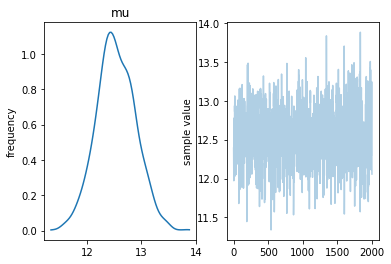

In [5]:
fit.plot()

In [6]:
np.mean(data["Y"])

12.5

## arvizで予測分布まで

In [7]:
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
schools = np.array(['Choate', 'Deerfield', 'Phillips Andover', 'Phillips Exeter',
                    'Hotchkiss', 'Lawrenceville', "St. Paul's", 'Mt. Hermon'])


In [8]:
schools_model = """
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}


sm = pystan.StanModel(model_code=schools_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0eada194ad938e30ed47926216f98ca NOW.


In [9]:
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

- パラメータの事後分布の可視化にはpystanではarvizを使う。

今回MCMCサンプリングしたあとの結果をfitに格納しているので```fit.plot()```もできるがwarningがでて

```arviz```を使うよう勧められる。

インストールはanacondaを使っていれば```conda install -c conda-forge arviz```

使い方詳しくは[公式](https://arviz-devs.github.io/arviz/notebooks/Introduction.html)

In [10]:
import arviz as az

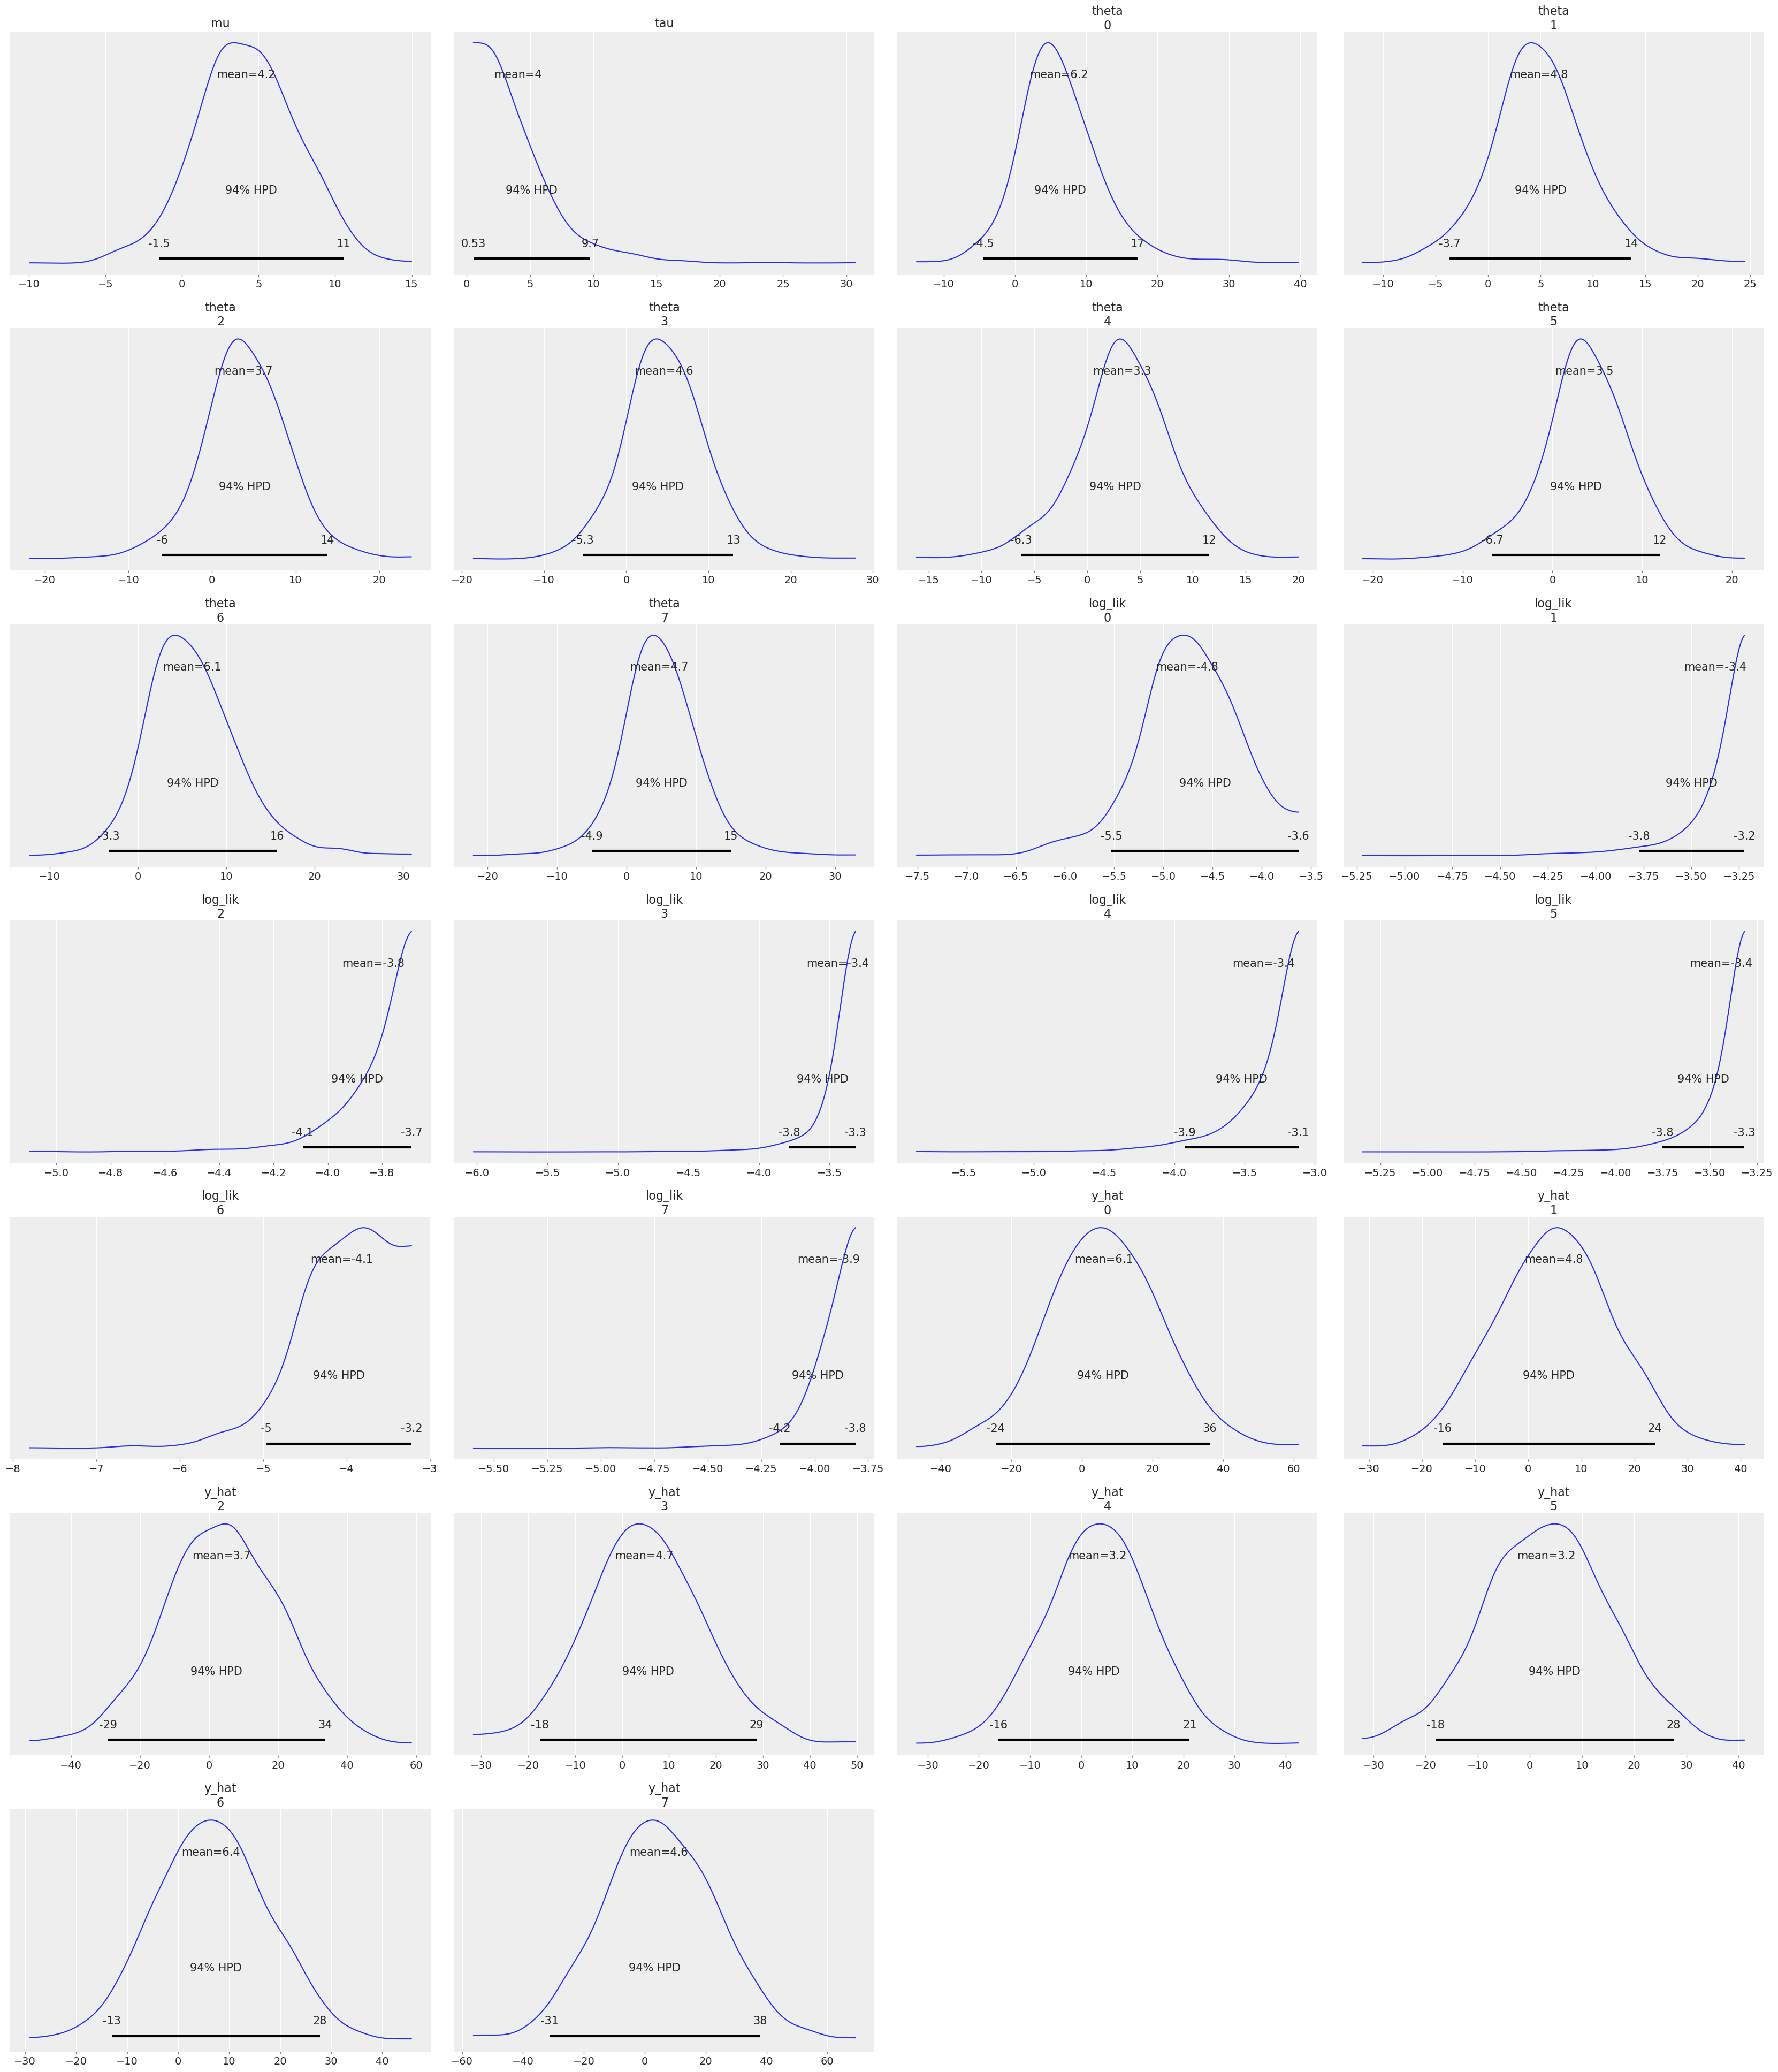

In [11]:
az.style.use("arviz-darkgrid")
az.plot_posterior(fit);

In [12]:
print(fit)

Inference for Stan model: anon_model_b0eada194ad938e30ed47926216f98ca.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu           4.18    0.16   3.23  -2.47   2.09   4.08   6.33  10.45    388   1.02
tau          4.05    0.25   3.28   0.55   1.83   3.14   5.24  12.88    171   1.02
theta[1]      6.2    0.31   5.76  -4.09   2.69   5.55   9.31  19.39    340   1.01
theta[2]     4.82    0.19   4.55  -4.21   2.13    4.6   7.43  14.44    592   1.01
theta[3]     3.75    0.19    5.2  -7.07   0.73   3.48   6.92  13.89    725    1.0
theta[4]     4.56    0.19   4.99  -4.99    1.6   4.35   7.52  14.75    666   1.01
theta[5]     3.29    0.18   4.64  -6.74   0.81   3.29   6.22  12.15    694   1.01
theta[6]     3.54    0.17   4.85  -6.83   1.03   3.51   6.67  12.61    827   1.01
theta[7]     6.12    0.24   5.14  -2.91   2.61   5.56   8.99  17.82    447 

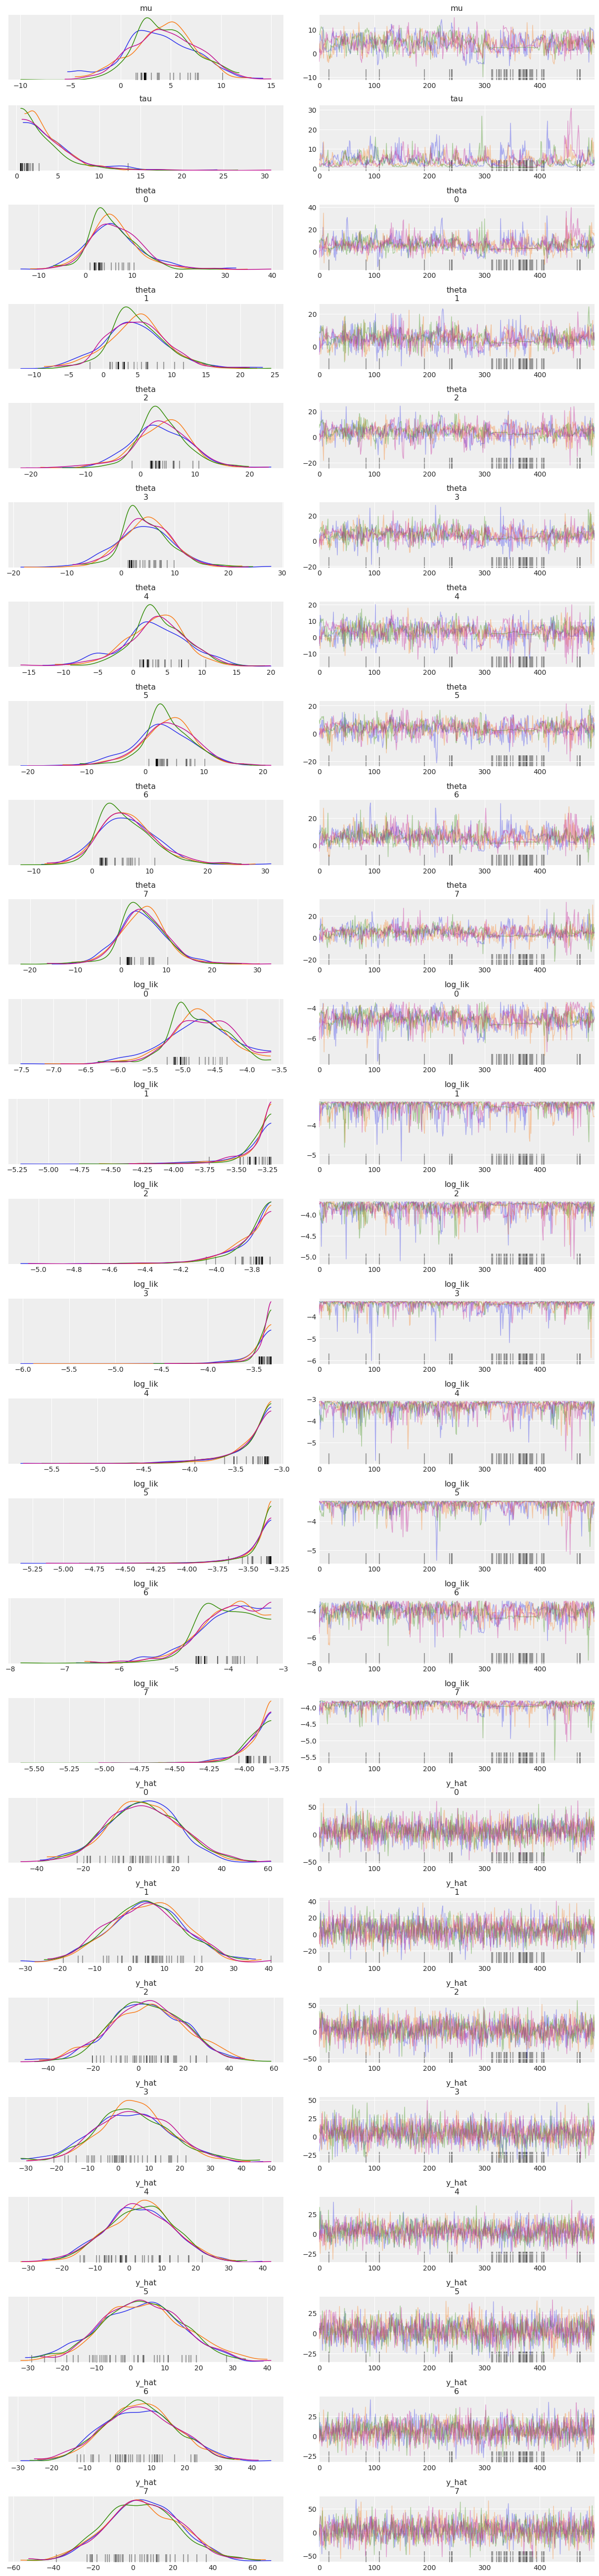

In [13]:
az.plot_trace(fit);

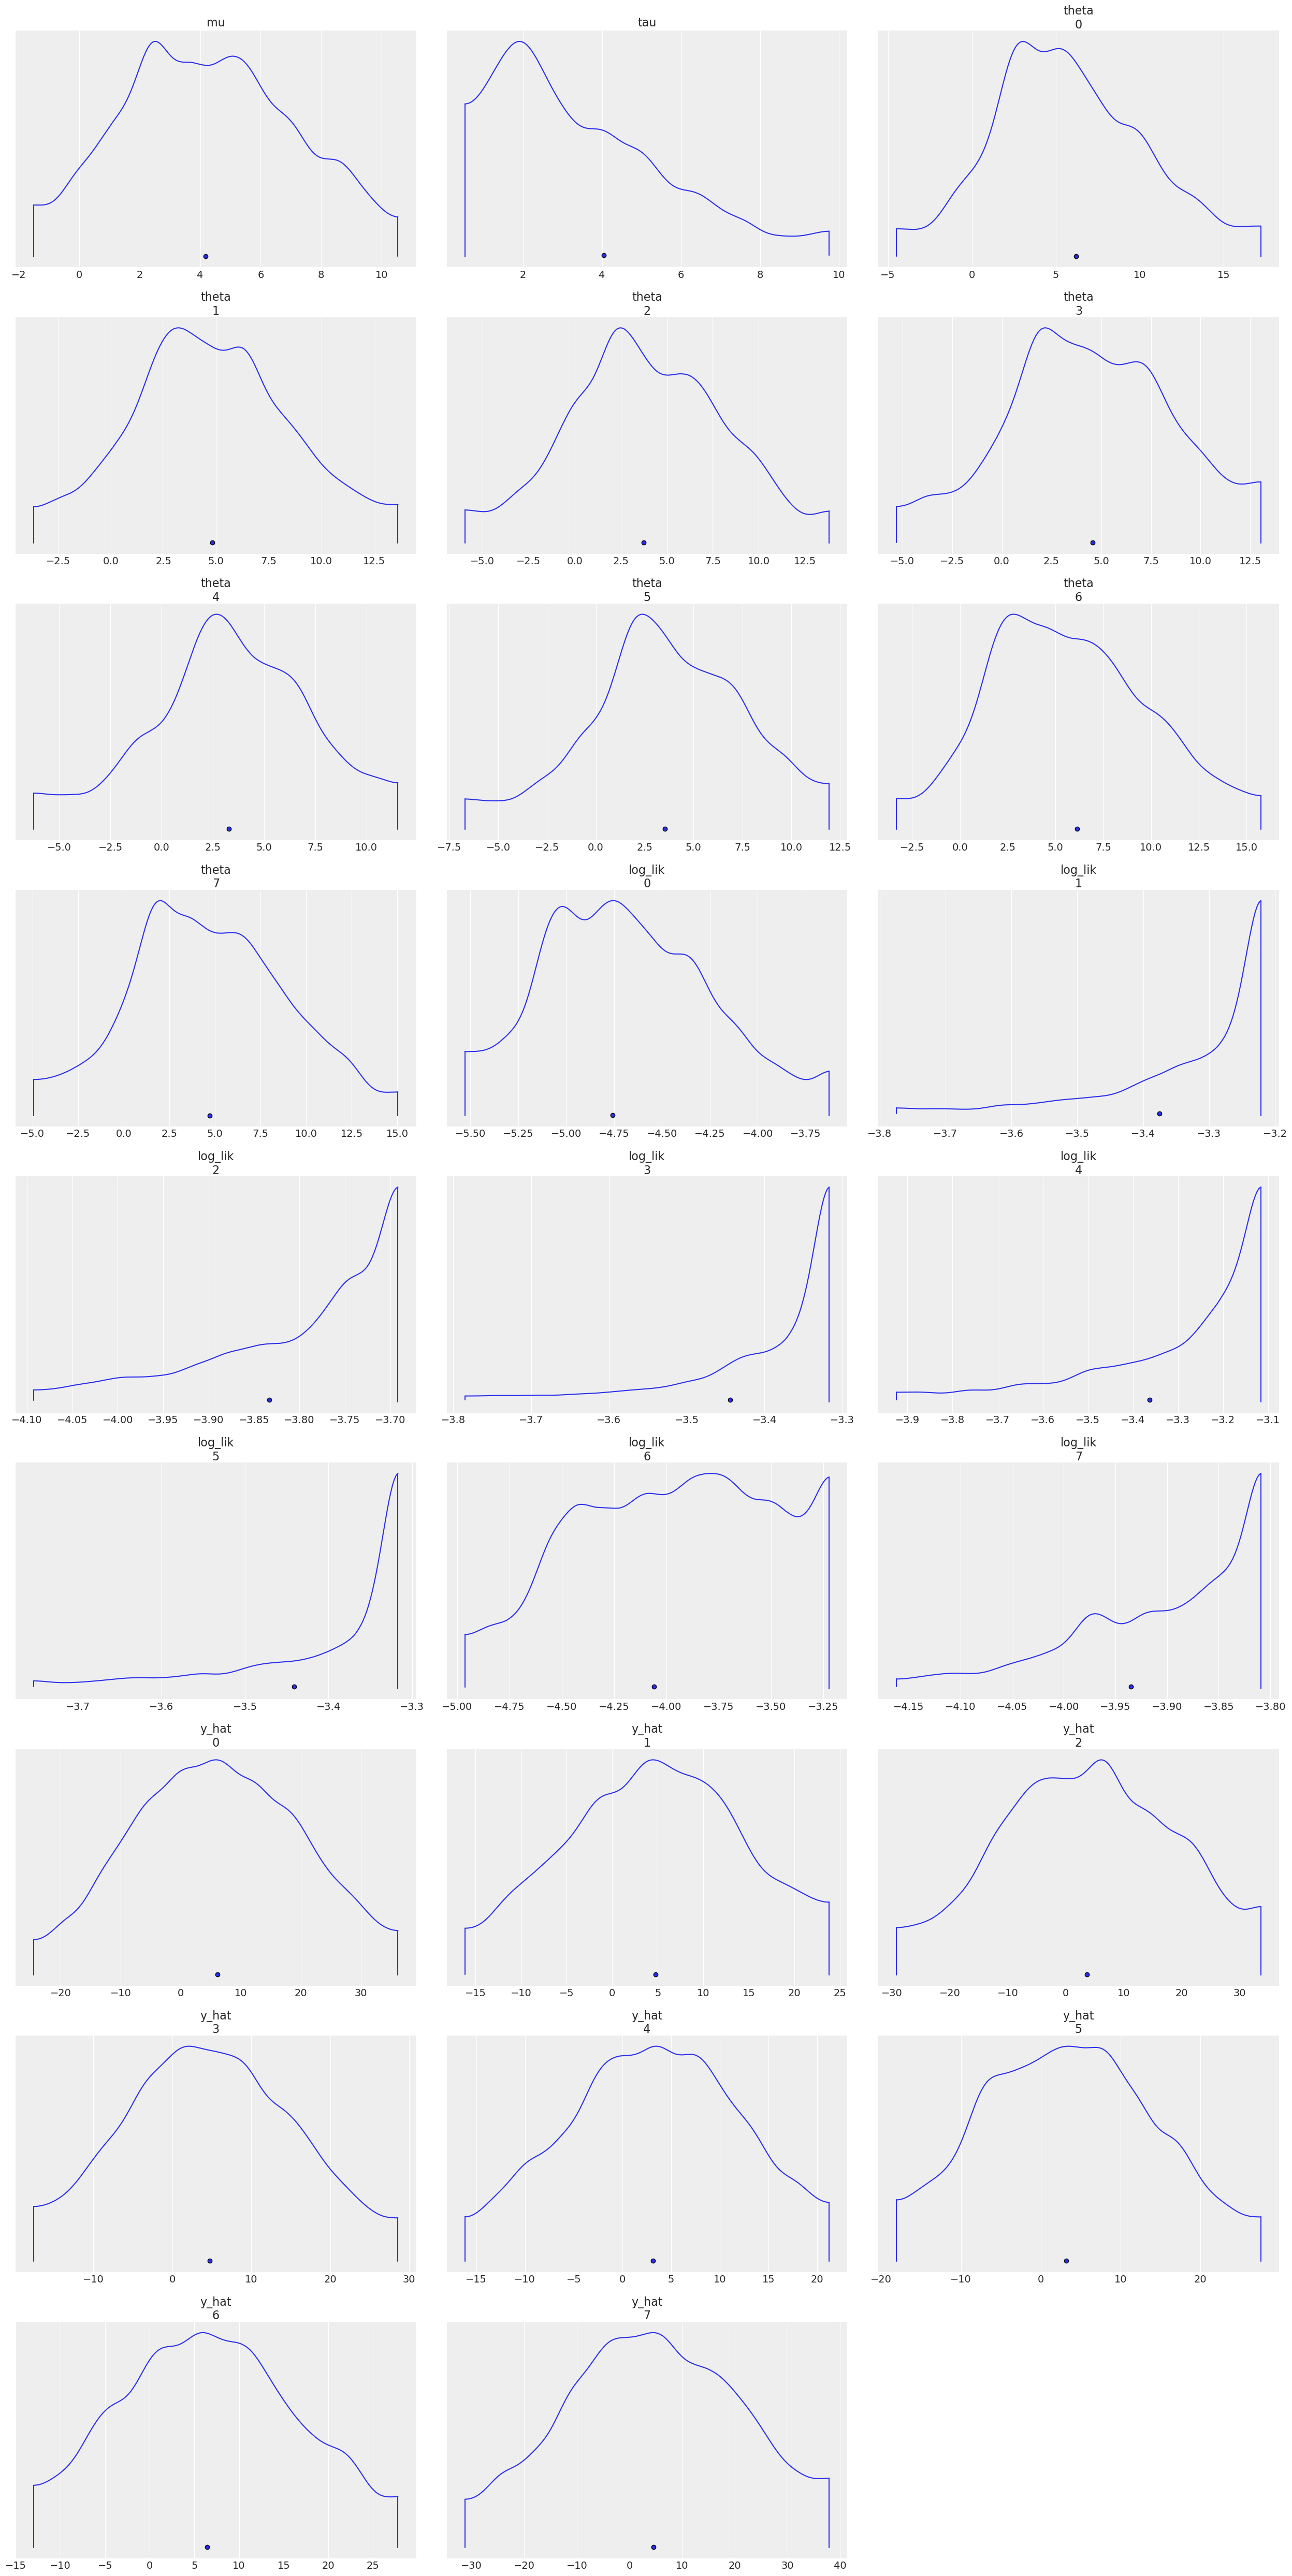

In [14]:
az.plot_density(fit);

今まではパラメータの事後分布$p(w|X) \propto p(X|w)p(w)$をMCMCサンプリングで近似的に求めたので、

そのパラメータの事後分布で確率モデルを平均した予測分布$p(x^*|X)=\int p(x*|w)p(w|X)$を求める。

ベイズ推定による統計モデリングでは、この予測分布とサンプルを発生している真の確率分布との誤差（汎化誤差）を小さくすることを目指す。

詳しくは、[ベイズ統計の理論と方法](http://watanabe-www.math.dis.titech.ac.jp/users/swatanab/bayes-theory-method.html)や[著者HPの講義資料やQA](http://watanabe-www.math.dis.titech.ac.jp/users/swatanab/index-j.html)を参照。

- [arviz.from_pystan document](https://arviz-devs.github.io/arviz/generated/arviz.from_pystan.html)

    - ```cords``` : インデックスとして使われてる値

In [25]:
data = az.from_pystan(
    posterior=fit,
    posterior_predictive='y_hat',
    observed_data=['y'],
    log_likelihood={'y': 'log_lik'},
    coords={'school': schools},
    dims={
        'theta': ['school'],
        'y': ['school'],
        'log_lik': ['school'],
        'y_hat': ['school'],
        'theta_tilde': ['school']
    }
)
data

Inference data with groups:
	> posterior
	> sample_stats
	> log_likelihood
	> posterior_predictive
	> observed_data

In [27]:
data.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 500, school: 8)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * school   (school) <U16 'Choate' 'Deerfield' ... "St. Paul's" 'Mt. Hermon'
Data variables:
    y_hat    (chain, draw, school) float64 12.79 -3.931 7.604 ... 26.39 -2.328
Attributes:
    created_at:                 2020-06-26T04:59:36.195297
    arviz_version:              0.7.0
    inference_library:          pystan
    inference_library_version:  2.19.0.0

/usr/local/Caskroom/miniconda/base/envs/work/lib/python3.7/site-packages/arviz/plots/pairplot.py:182: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  UserWarning,


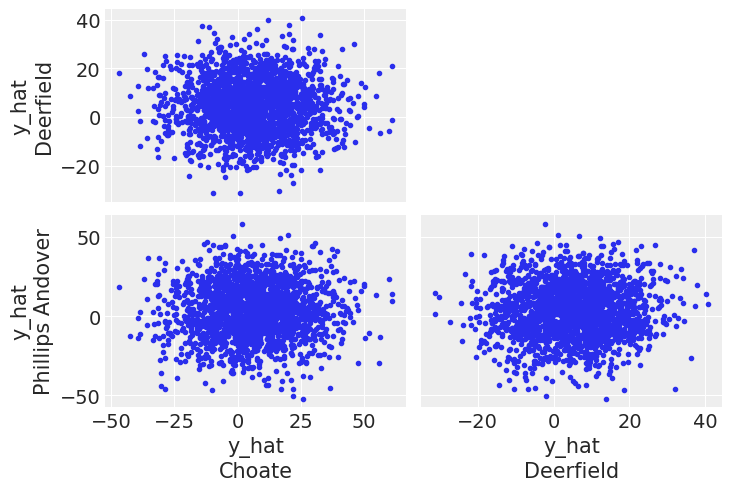

In [31]:
az.plot_pair(data.posterior_predictive, coords={'school': ['Choate', 'Deerfield', 'Phillips Andover']}, divergences=True);

In [18]:
data = az.convert_to_inference_data(fit)
data

Inference data with groups:
	> posterior
	> sample_stats

In [19]:
data.posterior

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 500, log_lik_dim_0: 8, theta_dim_0: 8, y_hat_dim_0: 8)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * theta_dim_0    (theta_dim_0) int64 0 1 2 3 4 5 6 7
  * log_lik_dim_0  (log_lik_dim_0) int64 0 1 2 3 4 5 6 7
  * y_hat_dim_0    (y_hat_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    mu             (chain, draw) float64 1.925 0.4661 7.81 ... 4.738 5.44 3.821
    tau            (chain, draw) float64 4.66 4.754 4.053 ... 2.289 2.127 2.404
    theta          (chain, draw, theta_dim_0) float64 -0.4884 5.913 ... 4.963
    log_lik        (chain, draw, log_lik_dim_0) float64 -5.431 -3.243 ... -3.886
    y_hat          (chain, draw, y_hat_dim_0) float64 12.79 -3.931 ... -2.328
Attributes:
    created_at:                 2020-06-26T04:56:27.797572
    arviz_version:              0.7.0
    inference_library:          pystan
    inference_library_version:  2.19.0.0

In [20]:
data.sample_stats

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 500)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    accept_stat  (chain, draw) float64 0.8372 0.7876 0.9673 ... 0.9658 0.9603
    stepsize     (chain, draw) float64 0.2251 0.2251 0.2251 ... 0.1791 0.1791
    treedepth    (chain, draw) int64 4 4 4 4 4 4 4 5 4 3 ... 3 3 4 3 3 3 3 2 3 3
    n_leapfrog   (chain, draw) int64 15 15 15 15 15 15 15 31 ... 7 7 7 7 7 7 15
    diverging    (chain, draw) bool False False False ... False False False
    energy       (chain, draw) float64 23.06 25.27 26.2 ... 13.51 14.68 16.27
    lp           (chain, draw) float64 -17.92 -18.79 -20.7 ... -13.08 -13.87
Attributes:
    created_at:                 2020-06-26T04:56:27.801210
    arviz_version:              0.7.0
    inference_library:          pystan
    inference_library_version:  2.19.0.0

In [21]:
inference_dist

NameError: name 'inference_dist' is not defined